In [2]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
from rdkit import Chem 
from rdkit.Chem import rdFMCS

from rdkit import RDLogger
RDLogger.logger().setLevel(RDLogger.CRITICAL)

from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, display
from rdkit.Chem.Draw import IPythonConsole

from dft_descriptors import numbering_CO as nb
from dft_descriptors import prepocessing as pp


In [78]:
double_coupling = ['']

def preprocess(df):
    # remove lines with nan substrate
    df = df[df["Reactant Smile (C-O)"].isna() == False]
    
    # remove reviews from dataframe:
    df = df[df["Mechanism"] != 'Review']
    
    # remove the doi : 'https://doi.org/10.1021/acs.orglett.5b03151' because it is a double reaction for dimerisation
    df = df[df["DOI"] != 'https://doi.org/10.1021/acs.orglett.5b03151']
    
    # 'https://doi.org/10.1021/acs.orglett.6b03861' ? intramoleculaire oxydative addition ?
    
    # remove the double steps reactions 
    df = df[df["2 Steps"] != "Yes"]
    
    # check smiles validity
    # Canon CO
    co_can = [Chem.CanonSmiles(smi) for smi in df["Reactant Smile (C-O)"]]
    # Canon AX
    ax_can = [Chem.CanonSmiles(smi) for smi in df["A-X effectif"]]
    # Canon Lig
    lig_can = []
    for lig in df["Ligand effectif"]:
        try:
            lig_can.append(Chem.CanonSmiles(pp.dict_ligand[lig]))
        except:
            lig_can.append(lig)
            
    # Canon Base
    add_can = pp.smiles_additifs(df["Base/additif après correction effective"])
            
    # Canon_df
    df["Reactant Smile (C-O)"] = co_can
    df["A-X effectif"] = ax_can
    df["Ligand effectif"] = lig_can
    df["Base/additif après correction effective"] = add_can
    
    return df

In [11]:
df = pd.read_csv("../data_csv/Data_test11032021.csv")
df2 = pp.preprocess(df)

In [12]:
df2.columns

Index(['Index', 'Reactant Smile (C-O)', 'A-X', 'A-X effectif', 'Solvent',
       'Time', 'Temperature', 'Precurseur Nickel', 'Base/additifs',
       'Base/additif après correction effective', 'Ligand', 'Ligand effectif',
       'Product', 'GC/NMR Yield', 'Isolated Yield', 'A-X type', 'Mechanism',
       'Unnamed: 17', 'DOI', 'type of data (Optimisation or scope)',
       'Notes : qu'est ce qui ne rentres pas dans le tableau', 'eq CO',
       'eq A-X', 'eq Ni', 'eq Lig (lig + prec)',
       'eq B (si reducteur pas pris en c0mpte)', '2 Steps',
       'Notes bis : modifications', 'Unnamed: 28', 'Unnamed: 29'],
      dtype='object')

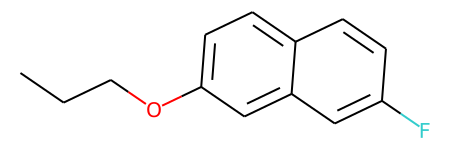

In [7]:
Chem.CanonSmiles\

In [85]:
# def visualisation d'une réaction en fonction de son "index"
def vis_rxn(index, df):
    ax = Chem.MolFromSmiles(df[df["Index"]==index]["A-X effectif"].to_list()[0])
    ax = Chem.MolToSmarts(ax)
    try:
        lig = Chem.MolFromSmiles(pp.dict_ligand[df[df["Index"]==index]['Ligand effectif'].to_list()])
        lig = Chem.MolToSmarts(lig)
    except:
        lig = Chem.MolToSmarts(Chem.MolFromSmiles(''))

    try:
        prec = Chem.MolFromSmiles(df[df["Index"]==index]['Precurseur Nickel'].to_list()[0])
        prec = Chem.MolToSmarts(prec)
    except:
        prec = Chem.MolToSmarts(Chem.MolFromSmiles('')) 

    reactant = Chem.MolFromSmiles(df[df["Index"]==index]['Reactant Smile (C-O)'].to_list()[0])
    reactant = Chem.MolToSmarts(reactant)
    product = Chem.MolFromSmiles(df[df["Index"]==index]['Product'].to_list()[0])
    product = Chem.MolToSmarts(product)
    reaction = reactant + '.' + ax + '>' + lig + prec + '>' + product

    # Pictet-Spengler rxn
    rxn = AllChem.ReactionFromSmarts(reaction)
    return rxn

def rxn_byDOI(DOI, df):
    df = df[df["DOI"] == DOI]
    indexes = df["Index"].to_list()
    for index in indexes:
        rxn = vis_rxn(index, df)
        Y = []
        Y.append(df[df["Index"] == index]["GC/NMR Yield"].to_list())
        Y.append(df[df["Index"] == index]["Isolated Yield"].to_list())
        d = Draw.MolDraw2DSVG(900, 300)
        d.DrawReaction(rxn)
        d.FinishDrawing()  
        svg = d.GetDrawingText()
        svg2 = svg.replace('svg:','')
        svg3 = SVG(svg2)
        display(svg3)
        print(index, Y)
        

def rxn_unique_byDOI(DOI, df):
    df = df[df["DOI"] == DOI]
    df = df[df.duplicated(subset= ['Reactant Smile (C-O)', 'A-X effectif', 'Product'],  keep = 'first') == False]
    indexes = df["Index"].to_list()
    for index in indexes:
        rxn = vis_rxn(index, df)
        Y = []
        Y.append(df[df["Index"] == index]["GC/NMR Yield"].to_list())
        Y.append(df[df["Index"] == index]["Isolated Yield"].to_list())
        d = Draw.MolDraw2DSVG(900, 300)
        d.DrawReaction(rxn)
        d.FinishDrawing()  
        svg = d.GetDrawingText()
        svg2 = svg.replace('svg:','')
        svg3 = SVG(svg2)
        display(svg3)
        print(index, Y)

In [86]:
dois = np.unique(df2["DOI"])
len(dois)

39

In [ ]:
def remove_double_couplings(df):
    double_couplings = []
    for idx in range(len(df)):
        try:
            r = Chem.MolFromSmiles(df.iloc[idx]["Reactant Smile (C-O)"])
            p = Chem.MolFromSmiles(df.iloc[idx]["Product"])
            r = Chem.rdmolops.AddHs(r)
            p = Chem.rdmolops.AddHs(p)
            mols = [r, p]
            res = rdFMCS.FindMCS(mols) 
            patt = Chem.MolFromSmarts(res.smartsString)
            rm = AllChem.DeleteSubstructs(r,patt)
            smi = Chem.MolToSmiles(rm)
            if '.' in smi:  
                double_couplings.append((idx, Chem.MolToSmiles(r), Chem.MolToSmiles(p)))
        except:
            print(df.iloc[idx].to_list())
            
    return double_couplings